In [1]:
import numpy as np

import uproot3
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)

from yahist import Hist1D, Hist2D

f_in = uproot3.open('/home/users/ksalyer/FranksFCNC/ana/analysis/outputs/v6BabyPlots/fakes_mc_2018_hists.root')

In [2]:
path = '/home/users/ksalyer/FranksFCNC/ana/analysis/outputs/v6BabyPlots/'

hists = {
    'fakes': uproot3.open(path+'fakes_mc_2018_hists.root')['h_sf_llpt_fakes_mc'],
    'flips': uproot3.open(path+'flips_mc_2018_hists.root')['h_sf_llpt_flips_mc'],
    'rares': uproot3.open(path+'rares_2018_hists.root')['h_sf_llpt_rares'],
    'data': uproot3.open(path+'data_2018_hists.root')['h_sf_llpt_data'],
    'tch': uproot3.open(path+'signal_tch_2018_hists.root')['h_sf_llpt_signal_tch'],
    'tuh': uproot3.open(path+'signal_tuh_2018_hists.root')['h_sf_llpt_signal_tuh'],
}

In [3]:
def get_yahist(hist, rebin=1, overflow=True):
    counts = hist.allvalues
    edges = hist.alledges
    w2 = hist.allvariances
    if overflow:
        counts[1] += counts[0]
        counts[-2] += counts[-1]
        w2[1] += w2[1]
        w2[-2] += w2[-1]
        counts = np.array(counts[1:-1])
        edges = np.array(edges[1:-1])
        w2 = np.array(w2[1:-1])
    
    tmp_hist = Hist1D.from_bincounts(counts, edges, np.sqrt(w2), )
    tmp_hist = tmp_hist.rebin(rebin)
    return tmp_hist


In [4]:
def get_total(histos, keys):
    tmp = Hist1D.from_bincounts(np.zeros(len(histos[keys[0]].counts)), histos[keys[0]].edges, )
    for key in keys:
        tmp += histos[key]
    
    return tmp

In [5]:
def add_uncertainty(hist, ax, ratio=False):
    opts = {'step': 'post', 'label': 'Uncertainty', 'hatch': '///',
                    'facecolor': 'none', 'edgecolor': (0, 0, 0, .5), 'linewidth': 0, 'zorder':10.}
    
    if ratio:
        down = np.ones(len(hist.counts)) - hist.errors/hist.counts
        up = np.ones(len(hist.counts)) + hist.errors/hist.counts
    else:
        down = hist.counts-hist.errors
        up = hist.counts+hist.errors
    ax.fill_between(x=hist.edges, y1=np.r_[down, down[-1]], y2=np.r_[up, up[-1]], **opts)

In [6]:
my_histos = { x:get_yahist(hists[x], rebin=10, overflow=True) for x in hists.keys() }

my_histos['fakes'].label = 'Nonprompt'
my_histos['fakes'].color = '#FF595E'

my_histos['flips'].label = 'Charge flip'
my_histos['flips'].color = '#FFCA3A'

my_histos['rares'].label = 'Other'
my_histos['rares'].color = '#8AC926'

keys = ['rares', 'flips', 'fakes']

signals = ['tch', 'tuh']

total_mc = get_total(my_histos, keys)

ratio = my_histos['data'].divide(total_mc, )


<ipython-input-5-e115ef79c901>:6: RuntimeWarning: invalid value encountered in true_divide
  down = np.ones(len(hist.counts)) - hist.errors/hist.counts
<ipython-input-5-e115ef79c901>:7: RuntimeWarning: invalid value encountered in true_divide
  up = np.ones(len(hist.counts)) + hist.errors/hist.counts


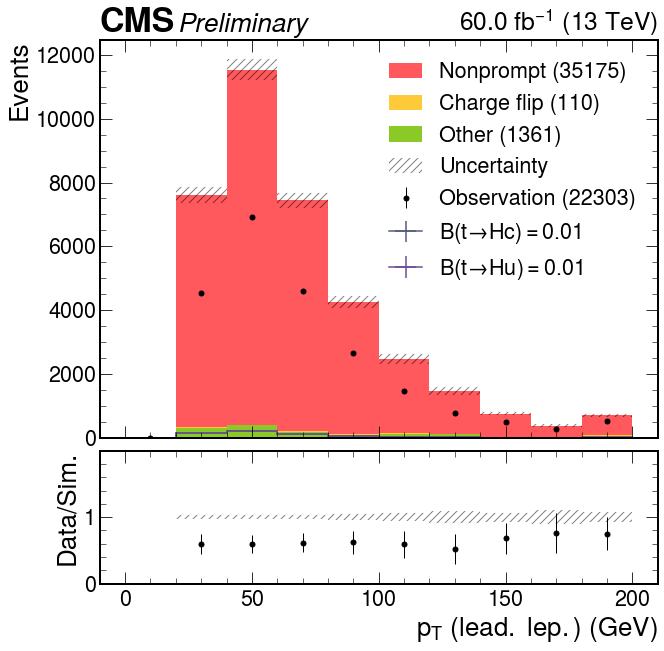

In [10]:
#f, ax = plt.subplots()

fig, (ax, rax) = plt.subplots(2,1,figsize=(10,10), gridspec_kw={"height_ratios": (3, 1), "hspace": 0.05}, sharex=True)

hep.cms.label(
    "Preliminary",
    data=True,
    #year=2018,
    lumi=60.0,
    loc=0,
    ax=ax,
)

hep.histplot(
    [ my_histos[x].counts for x in keys ],
    my_histos['fakes'].edges,
    w2=[ my_histos[x].errors for x in keys ],
    histtype="fill",
    stack=True,
    label=['%s (%.0f)'%(my_histos[x].label, sum(my_histos[x].counts)) for x in keys],
    color=[ my_histos[x].color for x in keys ],
    ax=ax)

hep.histplot(
    my_histos['data'].counts,
    my_histos['data'].edges,
    w2=my_histos['data'].errors,
    histtype="errorbar",
    stack=False,
    label='%s (%.0f)'%('Observation', sum(my_histos['data'].counts)),
    color='black',
    ax=ax)

hep.histplot(
    [my_histos['tch'].counts/100, my_histos['tuh'].counts/100],
    my_histos['tch'].edges,
    w2=[my_histos['tch'].errors/100, my_histos['tuh'].errors/100],
    histtype="step",
    stack=False,
    label=[r'$B(t\to Hc)=0.01$', r'$B(t\to Hu)=0.01$'],
    color=['#525B76','#6A4C93'],
    ax=ax)

hep.histplot(
    ratio.counts,
    ratio.edges,
    w2=ratio.errors,
    histtype="errorbar",
    color='black',
    ax=rax)

rax.set_ylim(0,1.99)
rax.set_xlabel(r'$p_T\ (lead.\ lep.)\ (GeV)$')
rax.set_ylabel(r'Data/Sim.')
ax.set_ylabel(r'Events')
#ax.set_yscale('log')
#ax.set_ylim(0.1,1e5)

add_uncertainty(total_mc, rax, ratio=True)
add_uncertainty(total_mc, ax)

ax.legend()

plt.show()

fig.savefig('/home/users/dspitzba/public_html/FCNC/example.png')
fig.savefig('/home/users/dspitzba/public_html/FCNC/example.pdf')

In [ ]:
help(ax.fill_between)